# 사전 설정 (colab)

In [1]:
# 필수 라이브러리 설치
# transformers: Hugging Face의 트랜스포머 모델들을 사용하기 위한 라이브러리
# FFmpeg: 비디오/오디오 처리를 위한 도구(코덱처리)
!pip install -U -q transformers
!pip install -q FFmpeg
# !pip install -q mediapipe
!pip install -q ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.1/40.1 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 50.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 28.0 MB/s eta 0:00:00


In [2]:
# Google Drive를 Colab 환경에 마운트
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# 작업 디렉토리를 헬스케어 해커톤 모델 폴더로 변경
%cd /content/drive/MyDrive/02.git/healthcare-hackathon/model

/content/drive/MyDrive/02.git/healthcare-hackathon/model


In [15]:
# 모듈 검색 경로에 fer2013-finetuning 디렉토리 추가
# FER2013 데이터셋 파인튜닝 관련 모듈들을 import하기 위함
import sys
sys.path.append('./fer2013-finetuning')

# 감정 분석 모델 관련 라이브러리 및 모듈 import
import torch  # PyTorch 딥러닝 프레임워크
from models.classifier import create_emotion_classifier  # 감정 분류 모델 생성 함수
from utils.dataset import create_dataloaders  # 데이터로더 생성 유틸리티
from utils.trainer import EmotionTrainer  # 감정 모델 훈련 클래스
from configs.config import Config  # 설정 파일

## 라이브러리

In [5]:
import cv2  # OpenCV를 사용한 비디오 파일 정보 추출
import torch  # PyTorch 딥러닝 프레임워크
from PIL import Image  # PIL(Python Imaging Library) - 이미지 처리를 위한 라이브러리
import time
from transformers import pipeline
import matplotlib.pyplot as plt

In [50]:
# Google Drive에서 테스트 비디오 파일 다운로드
# file_id = '1PTK0s1d8wh4D-346cD3APsF9p0dMQMhl'  # Google Drive 파일 ID
# !gdown {file_id} -O /content/test_vid.mp4  # gdown을 사용하여 비디오 다운로드

file_id = '1NAgNW1sXk9QdR84FR--_h2RmPXvTB1jz'
!gdown {file_id} -O /content/test_720p_vid.mp4  # 720p 화질의 기존과 다른 영상

# YOLO 가중치 파일
file_id = '1ZpmtGC27LH4gUMHsDEw4eMYBb4csL3o7'
!gdown {file_id} -O /content/yolov12-face.zip
!unzip /content/yolov12-face.zip -d /content/yolov12-face

Downloading...
From: https://drive.google.com/uc?id=1NAgNW1sXk9QdR84FR--_h2RmPXvTB1jz
To: /content/test_720p_vid.mp4
100% 22.2M/22.2M [00:00<00:00, 173MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1ZpmtGC27LH4gUMHsDEw4eMYBb4csL3o7
From (redirected): https://drive.google.com/uc?id=1ZpmtGC27LH4gUMHsDEw4eMYBb4csL3o7&confirm=t&uuid=6c7b0c63-7319-4feb-a6f8-e987cb08b0d4
To: /content/yolov12-face.zip
100% 109M/109M [00:01<00:00, 84.6MB/s] 
Archive:  /content/yolov12-face.zip
replace /content/yolov12-face/yolov12n-face.pt? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: /content/yolov12-face/yolov12n-face.pt  
  inflating: /content/yolov12-face/yolov12l-face.pt  
  inflating: /content/yolov12-face/yolov12m-face.pt  
  inflating: /content/yolov12-face/yolov12s-face.pt  


In [44]:
# Hugging Face에서 사전 학습된 감정 인식 모델을 사용하여 이미지 분류 파이프라인 생성
# ViT(Vision Transformer) 기반의 얼굴 표정 인식 모델 사용
pipe = pipeline("image-classification", model="mo-thecreator/vit-Facial-Expression-Recognition", use_fast=True)

Device set to use cuda:0


In [51]:
# OpenCV를 사용한 비디오 파일 정보 추출
test_vid = '/content/test_720p_vid.mp4'  # 테스트 비디오 파일 경로
cap = cv2.VideoCapture(test_vid)  # 비디오 캡처 객체 생성

# 비디오 속성 정보 가져오기
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))   # 비디오 너비
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)) # 비디오 높이
total_frame = cap.get(cv2.CAP_PROP_FRAME_COUNT)  # 총 프레임 수

# 비디오 정보 출력
print('width, height:',width, height)
print('total_frame:',total_frame)

width, height: 720 1280
total_frame: 5051.0


In [46]:
# 비디오 출력 설정 (사용되지 않음)
fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # MP4 비디오 코덱 설정
out = cv2.VideoWriter('output.mp4', fourcc, 30.0, (width, height))  # 비디오 라이터 객체 생성

# YOLOv12-Face로 faceDetect

In [63]:
import cv2
from ultralytics import YOLO

# YOLOv8 모델 로드 (얼굴 탐지용 사전 학습된 모델)
model = YOLO('/content/yolov12-face/yolov12l-face.pt')  # 얼굴 탐지용 YOLO 모델 파일

# 비디오 캡처 열기
cap = cv2.VideoCapture(test_vid)  # 비디오 캡처 객체 생성

# 결과를 저장할 리스트
frame_count = 0  # 프레임 카운터 초기화
emo_list = []    # 감정 분석 결과를 저장할 리스트
result_frames = []
time_st = time.time()

# 비디오의 모든 프레임을 순회하며 얼굴 탐지, 감정 분석 수행
while cap.isOpened():
  ret, frame = cap.read()  # 다음 프레임 읽기

  # 프레임 읽기 실패 시 종료
  if not ret:
      if emo_list == []:
        print('breaked')  # 감정 데이터가 없으면 중단됨
      else:
        print('ended')    # 정상 종료
        break

  # n프레임마다 감정 분석 수행
  if frame_count % 100 == 0:
      # YOLOv8을 사용하여 얼굴 탐지
      results = model(frame, verbose=False)

      # 감지된 얼굴에 바운딩 박스 그리기
      for result in results:
          boxes = result.boxes  # 바운딩 박스 정보
          for box in boxes:
              x1, y1, x2, y2 = map(int, box.xyxy[0])  # 바운딩 박스 좌표

              transform_img = Image.fromarray(cv2.cvtColor(frame[y1:y2, x1:x2], cv2.COLOR_BGR2RGB))
              cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)

          # 감지된 이미지를 result_frames 리스트에 추가
          result_frames.append(frame)

          # 감정 분석 수행
          result_cls = pipe(transform_img)

          # 상위 2개 감정 결과를 리스트에 추가
          for i, result in enumerate(result_cls):
            if i == 1:
              break
            emo_list.append(result['label'])

  frame_count += 1

# 비디오 캡처 해제
cap.release()
time_end = time.time()
runtime = time_end - time_st
print(f'실행시간 {runtime:.2f}sec')

ended
실행시간 17.65sec


In [64]:
result_cls

[{'label': 'neutral', 'score': 0.5815767645835876},
 {'label': 'happy', 'score': 0.24934940040111542},
 {'label': 'sad', 'score': 0.10221145302057266},
 {'label': 'anger', 'score': 0.028442302718758583},
 {'label': 'disgust', 'score': 0.02564787119626999}]

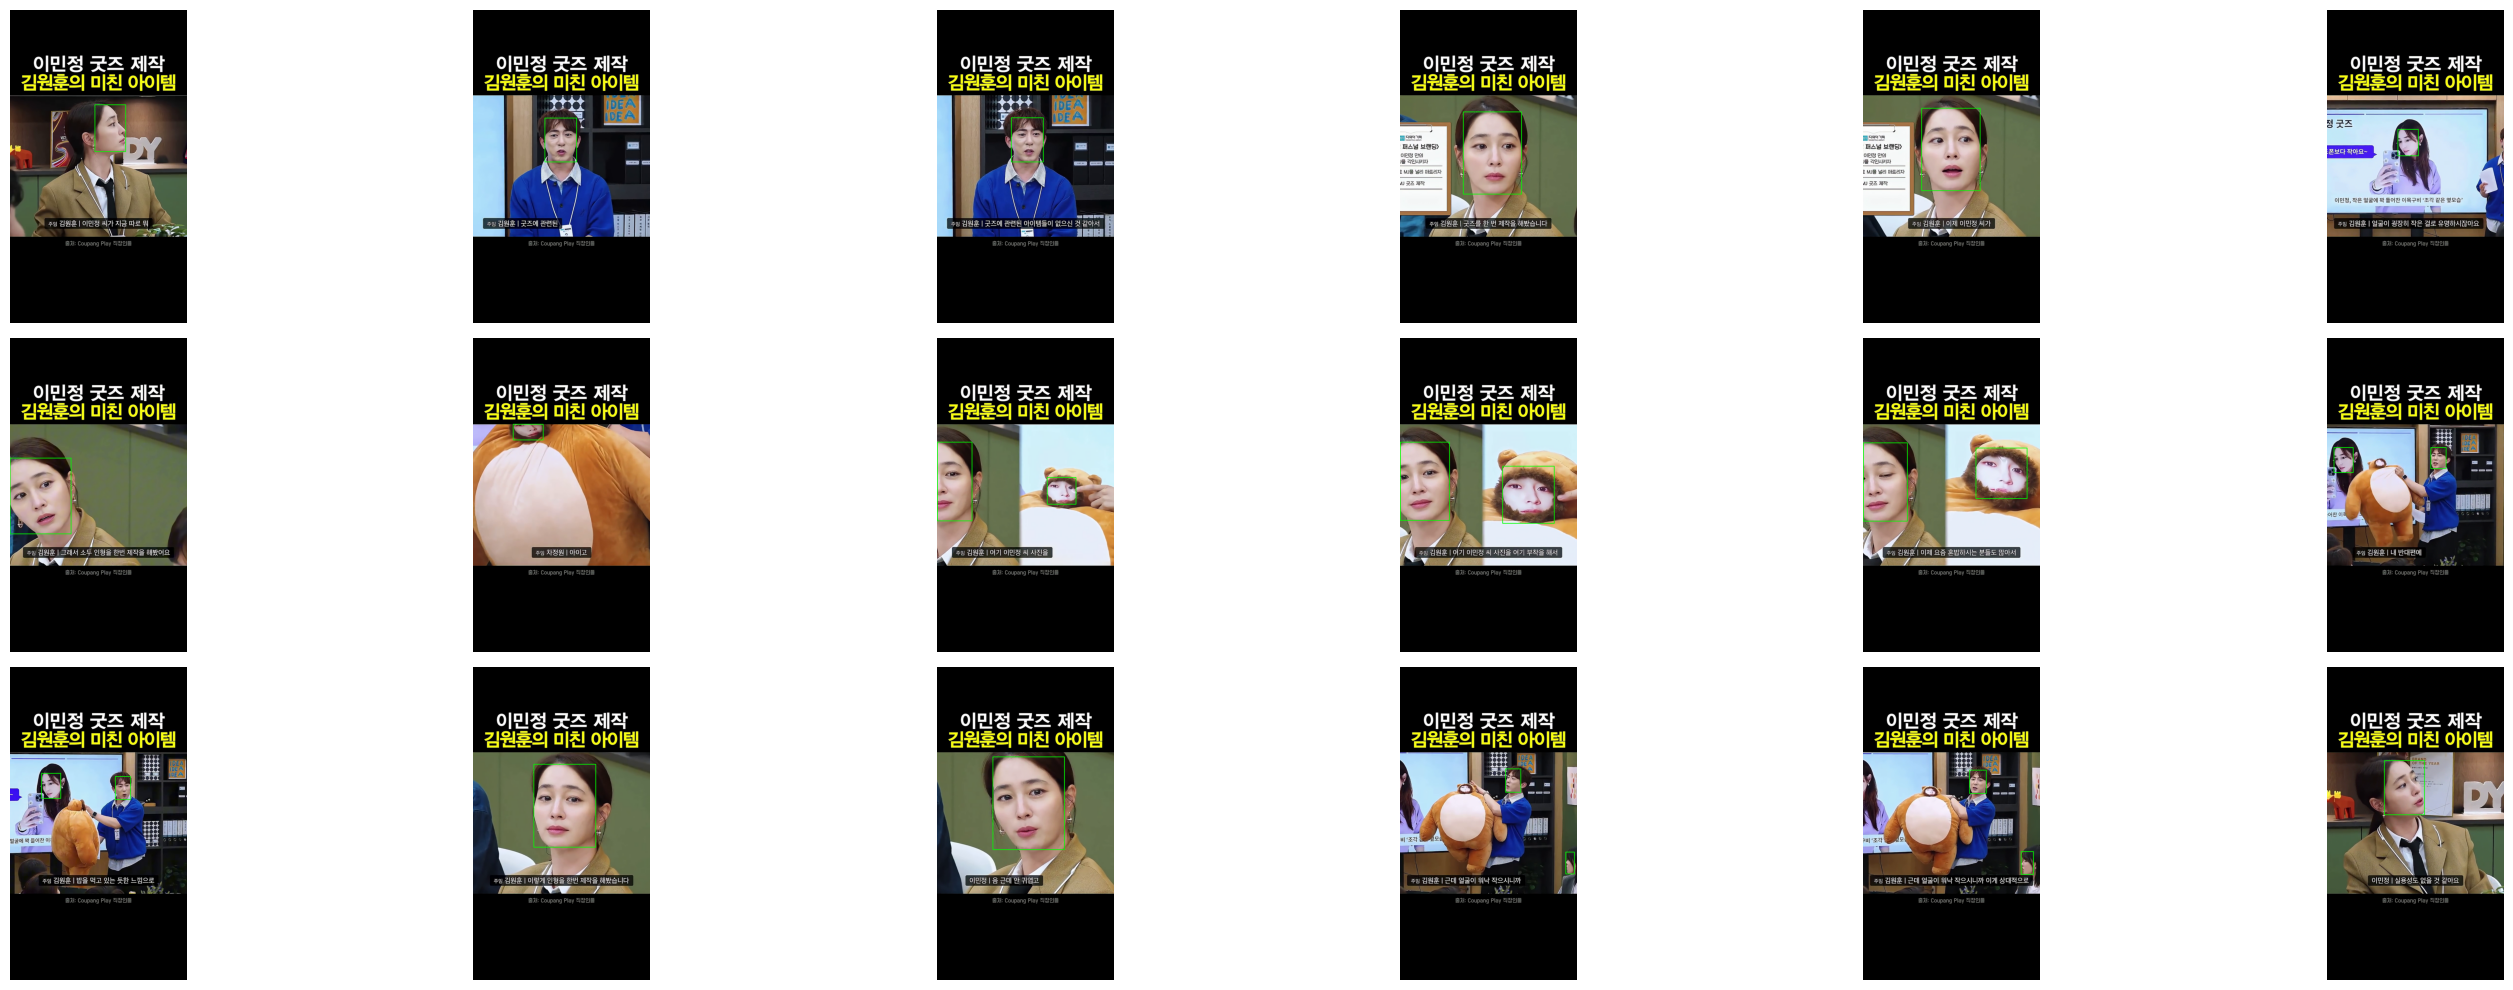

In [65]:
# 2행 6열 서브플롯 생성
fig, axes = plt.subplots(3, 6, figsize=(30, 10))

# result 리스트의 이미지를 서브플롯에 표시
for i, ax in enumerate(axes.flat):
    if i < len(result_frames):
        ax.imshow(cv2.cvtColor(result_frames[i], cv2.COLOR_BGR2RGB))  # BGR을 RGB로 변환
    ax.axis('off')  # 축 숨기기

plt.tight_layout()
plt.show()

In [66]:
i = 1
term = 1
for emo in emo_list:
  if term % 2 == 0 :
    print(f'{i} 번째 감정 {emo}')
    print('')
    term += 1
    i += 1

  else:
    print(f'{i} 번째 감정 {emo}')
    term += 1

1 번째 감정 sad
1 번째 감정 disgust

2 번째 감정 fear
2 번째 감정 sad

3 번째 감정 surprise
3 번째 감정 neutral

4 번째 감정 surprise
4 번째 감정 neutral

5 번째 감정 surprise
5 번째 감정 surprise

6 번째 감정 anger
6 번째 감정 happy

7 번째 감정 surprise
7 번째 감정 sad

8 번째 감정 sad
8 번째 감정 sad

9 번째 감정 neutral
9 번째 감정 sad

10 번째 감정 sad
10 번째 감정 sad

11 번째 감정 sad
11 번째 감정 sad

12 번째 감정 anger
12 번째 감정 sad

13 번째 감정 disgust
13 번째 감정 surprise

14 번째 감정 disgust
14 번째 감정 fear

15 번째 감정 disgust
15 번째 감정 disgust

16 번째 감정 neutral
16 번째 감정 neutral

17 번째 감정 anger
17 번째 감정 sad

18 번째 감정 sad
18 번째 감정 sad

19 번째 감정 sad
19 번째 감정 sad

20 번째 감정 disgust
20 번째 감정 disgust

21 번째 감정 sad
21 번째 감정 sad

22 번째 감정 happy
22 번째 감정 fear

23 번째 감정 surprise
23 번째 감정 anger

24 번째 감정 disgust
24 번째 감정 disgust

25 번째 감정 neutral
25 번째 감정 sad

26 번째 감정 neutral


In [67]:
# 감정별 카운트를 저장할 딕셔너리 초기화
emo_map = {
    'angry' : 0,     # 화남
    'disgust' : 0,   # 혐오
    'fear' : 0,      # 두려움
    'happy' : 0,     # 기쁨
    'neutral' : 0,   # 중립
    'sad' : 0,       # 슬픔
    'surprise' : 0   # 놀람
}

# 테스트: angry 감정의 초기값 확인
emo_map['angry']

# angry 감정의 등장 횟수를 카운트하여 업데이트
emo_map['angry'] = emo_map['angry'] + emo_list.count('angry')
emo_map  # 업데이트된 감정 맵 확인

{'angry': 0,
 'disgust': 0,
 'fear': 0,
 'happy': 0,
 'neutral': 0,
 'sad': 0,
 'surprise': 0}

In [68]:
# 모든 감정에 대해 카운트를 업데이트하고 이모지와 함께 결과 출력
for emo, count in emo_map.items():
  # 각 감정의 등장 횟수를 emo_list에서 카운트하여 업데이트
  emo_map[emo] = emo_map[emo] + emo_list.count(emo)

  # 각 감정에 해당하는 이모지 설정
  if emo == 'angry':
    face = '😡'      # 화남
  if emo == 'disgust':
    face = '🤢'      # 혐오
  if emo == 'fear':
    face = '😨'      # 두려움
  if emo == 'happy':
    face = '😄'      # 기쁨
  if emo == 'neutral':
    face = '😐'      # 중립
  if emo == 'sad':
    face = '😭'      # 슬픔
  if emo == 'surprise':
    face = '😮'      # 놀람

  # 감정별 통계 결과를 이모지와 함께 출력
  print(f'{face}감정: {emo}, ✅등장 횟수: {emo_map[emo]}\n')

😡감정: angry, ✅등장 횟수: 0

🤢감정: disgust, ✅등장 횟수: 9

😨감정: fear, ✅등장 횟수: 3

😄감정: happy, ✅등장 횟수: 2

😐감정: neutral, ✅등장 횟수: 7

😭감정: sad, ✅등장 횟수: 19

😮감정: surprise, ✅등장 횟수: 7

